In [1]:
print("hello")

hello


In [2]:
# NEW PROJET "the directed connectivity between the PFC and HPC"

PFC-HPC DIRECTED CONNECTIVITY ANALYSIS
Sampling Frequency: 2500 Hz

----------------------------------------
LOADING DATA
----------------------------------------

Loading HPC data: HPC_100_CH46.continuous.mat

Loading PFC data: PFC_100_CH11.continuous.mat

Loading States data: post_trial2_2017-09-27_11-46-56-statesAlysha.mat

States data shape: (2685,)
Unique state values: [1 3 4 5]

Truncating all data to 2685 samples (1.1 seconds)

Preprocessing whole session...

--------------------------------------------------
Granger Causality Analysis: Whole Session
--------------------------------------------------
  Data length: 2685 samples (1.07 seconds)
  Testing HPC → PFC direction...
  Testing PFC → HPC direction...

ANALYZING BY BRAIN STATES
Found states: [1 3 4 5]

----------------------------------------
Analyzing State 1
----------------------------------------
  Insufficient data: 0.5 seconds (<5s)

----------------------------------------
Analyzing State 3
-------------------------

Traceback (most recent call last):
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_25140\697498890.py", line 524, in main
    plot_connectivity_results(hpc_clean, pfc_clean, whole_results, state_results)
  File "C:\Users\pc\AppData\Local\Temp\ipykernel_25140\697498890.py", line 243, in plot_connectivity_results
    ax5.set_xticklabels(lags[::5])
  File "F:\app\anaconda\Lib\site-packages\matplotlib\axes\_base.py", line 74, in wrapper
    return get_method(self)(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "F:\app\anaconda\Lib\site-packages\matplotlib\axis.py", line 2071, in set_ticklabels
    raise ValueError(
ValueError: The number of FixedLocator locations (50), usually from a call to set_ticks, does not match the number of labels (10).


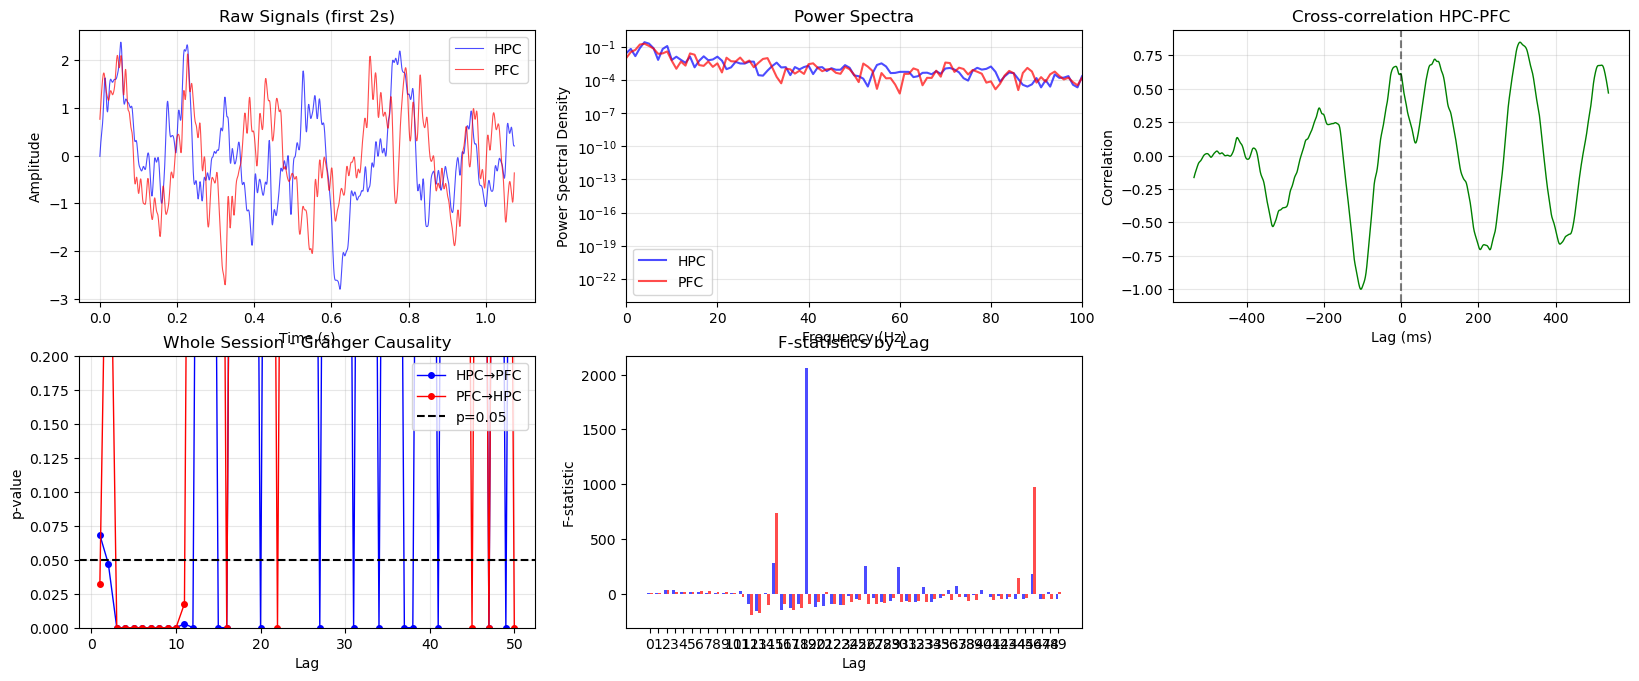

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
import os
from scipy.io import loadmat
warnings.filterwarnings('ignore')

# Set your file paths
HPC_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\HPC_100_CH46.continuous.mat"
PFC_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\PFC_100_CH11.continuous.mat"
STATES_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\post_trial2_2017-09-27_11-46-56-statesAlysha.mat"

FS = 2500  # Sampling frequency in Hz

def load_data_safely(file_path, description=""):
    """
    Safely load data from .mat file
    """
    print(f"\nLoading {description}: {os.path.basename(file_path)}")
    
    mat_data = loadmat(file_path)
    
    # Try to extract data
    for key in mat_data.keys():
        if not key.startswith('__'):
            data = mat_data[key]
            if isinstance(data, np.ndarray) and data.size > 0:
                return data.flatten()
    
    raise ValueError(f"Could not extract data from {file_path}")

def preprocess_data(data, fs=FS):
    """
    Preprocess neural signals
    """
    # Remove mean and detrend
    data = data - np.mean(data)
    data = signal.detrend(data)
    
    # Design filters
    nyquist = fs / 2
    
    # Bandpass filter (1-100 Hz for neural signals)
    b, a = signal.butter(4, [1/nyquist, 100/nyquist], btype='band')
    data_filtered = signal.filtfilt(b, a, data)
    
    # Notch filter for 50 Hz line noise
    b_notch, a_notch = signal.iirnotch(50, 30, fs)
    data_filtered = signal.filtfilt(b_notch, a_notch, data_filtered)
    
    # Normalize
    data_normalized = (data_filtered - np.mean(data_filtered)) / np.std(data_filtered)
    
    return data_normalized

def granger_causality_analysis(hpc, pfc, max_lag=50, name=""):
    """
    Perform Granger Causality analysis
    """
    print(f"\n{'-'*50}")
    print(f"Granger Causality Analysis: {name}")
    print(f"{'-'*50}")
    
    min_len = min(len(hpc), len(pfc))
    hpc = hpc[:min_len]
    pfc = pfc[:min_len]
    
    print(f"  Data length: {min_len} samples ({min_len/FS:.2f} seconds)")
    
    # Combine data
    data = np.column_stack([hpc, pfc])
    
    # Test both directions
    results = {'hpc_to_pfc': {}, 'pfc_to_hpc': {}}
    
    print("  Testing HPC → PFC direction...")
    gc_hpc_to_pfc = grangercausalitytests(data[:, [1, 0]], max_lag, verbose=False)
    
    print("  Testing PFC → HPC direction...")
    gc_pfc_to_hpc = grangercausalitytests(data, max_lag, verbose=False)
    
    for lag in range(1, max_lag + 1):
        # HPC → PFC
        try:
            hpc_to_pfc_ssr = gc_hpc_to_pfc[lag][0]['ssr_ftest']
            results['hpc_to_pfc'][lag] = {
                'f_stat': hpc_to_pfc_ssr[0],
                'p_value': hpc_to_pfc_ssr[1]
            }
        except:
            results['hpc_to_pfc'][lag] = {'f_stat': np.nan, 'p_value': np.nan}
        
        # PFC → HPC
        try:
            pfc_to_hpc_ssr = gc_pfc_to_hpc[lag][0]['ssr_ftest']
            results['pfc_to_hpc'][lag] = {
                'f_stat': pfc_to_hpc_ssr[0],
                'p_value': pfc_to_hpc_ssr[1]
            }
        except:
            results['pfc_to_hpc'][lag] = {'f_stat': np.nan, 'p_value': np.nan}
    
    return results

def analyze_by_states(hpc, pfc, states):
    """
    Analyze connectivity separately for each brain state
    """
    print("\n" + "="*60)
    print("ANALYZING BY BRAIN STATES")
    print("="*60)
    
    # Define state names based on your data
    state_names = {
        1: "State 1",
        2: "State 2", 
        3: "State 3",
        4: "State 4",
        5: "State 5"
    }
    
    # Get unique states
    unique_states = np.unique(states)
    print(f"Found states: {unique_states}")
    
    state_results = {}
    
    for state in unique_states:
        if np.isnan(state):
            continue
            
        state_name = state_names.get(state, f"State {state}")
        print(f"\n{'-'*40}")
        print(f"Analyzing {state_name}")
        print(f"{'-'*40}")
        
        # Get indices for this state
        state_idx = np.where(states == state)[0]
        
        if len(state_idx) < FS * 5:  # Need at least 5 seconds
            print(f"  Insufficient data: {len(state_idx)/FS:.1f} seconds (<5s)")
            continue
        
        # Extract state-specific data
        hpc_state = hpc[state_idx]
        pfc_state = pfc[state_idx]
        
        print(f"  Duration: {len(state_idx)/FS:.1f} seconds")
        
        # Preprocess
        hpc_clean = preprocess_data(hpc_state)
        pfc_clean = preprocess_data(pfc_state)
        
        # Granger causality
        results = granger_causality_analysis(hpc_clean, pfc_clean, max_lag=50, 
                                             name=state_name)
        
        state_results[state] = {
            'name': state_name,
            'duration': len(state_idx)/FS,
            'results': results
        }
    
    return state_results

def plot_connectivity_results(hpc, pfc, whole_results, state_results=None):
    """
    Create comprehensive visualization of connectivity results
    """
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Raw signals (first 2 seconds)
    ax1 = plt.subplot(3, 3, 1)
    time = np.arange(min(2*FS, len(hpc))) / FS
    ax1.plot(time, hpc[:len(time)], 'b-', alpha=0.7, label='HPC', linewidth=0.8)
    ax1.plot(time, pfc[:len(time)], 'r-', alpha=0.7, label='PFC', linewidth=0.8)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Raw Signals (first 2s)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Power spectra
    ax2 = plt.subplot(3, 3, 2)
    f_hpc, psd_hpc = signal.welch(hpc, FS, nperseg=FS)
    f_pfc, psd_pfc = signal.welch(pfc, FS, nperseg=FS)
    
    ax2.semilogy(f_hpc, psd_hpc, 'b-', label='HPC', alpha=0.7)
    ax2.semilogy(f_pfc, psd_pfc, 'r-', label='PFC', alpha=0.7)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power Spectral Density')
    ax2.set_title('Power Spectra')
    ax2.set_xlim([0, 100])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Cross-correlation
    ax3 = plt.subplot(3, 3, 3)
    corr = np.correlate(hpc[:5000], pfc[:5000], mode='same')
    corr = corr / np.max(np.abs(corr))
    lags = np.linspace(-len(corr)//2, len(corr)//2, len(corr)) / FS * 1000  # in ms
    ax3.plot(lags, corr, 'g-', linewidth=1)
    ax3.set_xlabel('Lag (ms)')
    ax3.set_ylabel('Correlation')
    ax3.set_title('Cross-correlation HPC-PFC')
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    
    # 4. Whole session Granger causality
    ax4 = plt.subplot(3, 3, 4)
    if whole_results:
        lags = list(whole_results['hpc_to_pfc'].keys())
        hpc_to_pfc_pvals = [whole_results['hpc_to_pfc'][lag]['p_value'] for lag in lags]
        pfc_to_hpc_pvals = [whole_results['pfc_to_hpc'][lag]['p_value'] for lag in lags]
        
        ax4.plot(lags, hpc_to_pfc_pvals, 'bo-', label='HPC→PFC', markersize=4, linewidth=1)
        ax4.plot(lags, pfc_to_hpc_pvals, 'ro-', label='PFC→HPC', markersize=4, linewidth=1)
        ax4.axhline(y=0.05, color='k', linestyle='--', label='p=0.05')
        ax4.set_xlabel('Lag')
        ax4.set_ylabel('p-value')
        ax4.set_title('Whole Session - Granger Causality')
        ax4.set_ylim([0, 0.2])
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # 5. Whole session F-statistics
    ax5 = plt.subplot(3, 3, 5)
    if whole_results:
        hpc_to_pfc_f = [whole_results['hpc_to_pfc'][lag]['f_stat'] for lag in lags]
        pfc_to_hpc_f = [whole_results['pfc_to_hpc'][lag]['f_stat'] for lag in lags]
        
        x = np.arange(len(lags))
        width = 0.35
        ax5.bar(x - width/2, hpc_to_pfc_f, width, label='HPC→PFC', color='blue', alpha=0.7)
        ax5.bar(x + width/2, pfc_to_hpc_f, width, label='PFC→HPC', color='red', alpha=0.7)
        ax5.set_xlabel('Lag')
        ax5.set_ylabel('F-statistic')
        ax5.set_title('F-statistics by Lag')
        ax5.set_xticks(x)
        ax5.set_xticklabels(lags[::5])
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # 6. Best lag comparison
    ax6 = plt.subplot(3, 3, 6)
    if whole_results:
        best_hpc = min(whole_results['hpc_to_pfc'].items(), key=lambda x: x[1]['p_value'])
        best_pfc = min(whole_results['pfc_to_hpc'].items(), key=lambda x: x[1]['p_value'])
        
        directions = ['HPC→PFC', 'PFC→HPC']
        best_lags = [best_hpc[0], best_pfc[0]]
        best_f = [best_hpc[1]['f_stat'], best_pfc[1]['f_stat']]
        colors = ['blue', 'red']
        
        bars = ax6.bar(directions, best_f, color=colors, alpha=0.7)
        ax6.set_ylabel('F-statistic (best lag)')
        ax6.set_title('Best Lag Comparison')
        ax6.grid(True, alpha=0.3)
        
        # Add lag values on top of bars
        for bar, lag in zip(bars, best_lags):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'lag={lag}\n({lag/FS*1000:.1f}ms)',
                    ha='center', va='bottom')
    
    # 7-9. State-dependent results (if available)
    if state_results:
        states_list = list(state_results.keys())
        for i, state in enumerate(states_list[:3]):  # Show up to 3 states
            ax = plt.subplot(3, 3, 7 + i)
            data = state_results[state]
            results = data['results']
            
            if results:
                lags = list(results['hpc_to_pfc'].keys())
                hpc_to_pfc_pvals = [results['hpc_to_pfc'][lag]['p_value'] for lag in lags]
                pfc_to_hpc_pvals = [results['pfc_to_hpc'][lag]['p_value'] for lag in lags]
                
                ax.plot(lags, hpc_to_pfc_pvals, 'bo-', label='HPC→PFC', markersize=3, linewidth=0.8)
                ax.plot(lags, pfc_to_hpc_pvals, 'ro-', label='PFC→HPC', markersize=3, linewidth=0.8)
                ax.axhline(y=0.05, color='k', linestyle='--', alpha=0.5)
                ax.set_xlabel('Lag')
                ax.set_ylabel('p-value')
                ax.set_title(f"{data['name']}\n({data['duration']:.1f}s)")
                ax.set_ylim([0, 0.2])
                ax.grid(True, alpha=0.3)
                if i == 0:
                    ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_state_comparison(state_results):
    """
    Plot comparison of connectivity across states
    """
    if not state_results:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Minimum p-values by state
    ax1 = axes[0, 0]
    states = []
    hpc_min_p = []
    pfc_min_p = []
    durations = []
    
    for state, data in state_results.items():
        states.append(data['name'])
        durations.append(data['duration'])
        results = data['results']
        
        if results:
            hpc_min = min(results['hpc_to_pfc'].items(), key=lambda x: x[1]['p_value'])
            pfc_min = min(results['pfc_to_hpc'].items(), key=lambda x: x[1]['p_value'])
            hpc_min_p.append(hpc_min[1]['p_value'])
            pfc_min_p.append(pfc_min[1]['p_value'])
        else:
            hpc_min_p.append(1)
            pfc_min_p.append(1)
    
    x = np.arange(len(states))
    width = 0.35
    ax1.bar(x - width/2, hpc_min_p, width, label='HPC→PFC', color='blue', alpha=0.7)
    ax1.bar(x + width/2, pfc_min_p, width, label='PFC→HPC', color='red', alpha=0.7)
    ax1.axhline(y=0.05, color='k', linestyle='--', label='p=0.05')
    ax1.set_xlabel('Brain State')
    ax1.set_ylabel('Minimum p-value')
    ax1.set_title('Best Connectivity by State')
    ax1.set_xticks(x)
    ax1.set_xticklabels(states, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. F-statistics comparison
    ax2 = axes[0, 1]
    hpc_max_f = []
    pfc_max_f = []
    
    for state, data in state_results.items():
        results = data['results']
        if results:
            hpc_best = min(results['hpc_to_pfc'].items(), key=lambda x: x[1]['p_value'])
            pfc_best = min(results['pfc_to_hpc'].items(), key=lambda x: x[1]['p_value'])
            hpc_max_f.append(hpc_best[1]['f_stat'])
            pfc_max_f.append(pfc_best[1]['f_stat'])
        else:
            hpc_max_f.append(0)
            pfc_max_f.append(0)
    
    ax2.bar(x - width/2, hpc_max_f, width, label='HPC→PFC', color='blue', alpha=0.7)
    ax2.bar(x + width/2, pfc_max_f, width, label='PFC→HPC', color='red', alpha=0.7)
    ax2.set_xlabel('Brain State')
    ax2.set_ylabel('F-statistic (best lag)')
    ax2.set_title('Connection Strength by State')
    ax2.set_xticks(x)
    ax2.set_xticklabels(states, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Best lags by state
    ax3 = axes[1, 0]
    hpc_best_lag = []
    pfc_best_lag = []
    
    for state, data in state_results.items():
        results = data['results']
        if results:
            hpc_best = min(results['hpc_to_pfc'].items(), key=lambda x: x[1]['p_value'])
            pfc_best = min(results['pfc_to_hpc'].items(), key=lambda x: x[1]['p_value'])
            hpc_best_lag.append(hpc_best[0])
            pfc_best_lag.append(pfc_best[0])
        else:
            hpc_best_lag.append(0)
            pfc_best_lag.append(0)
    
    ax3.bar(x - width/2, np.array(hpc_best_lag)/FS*1000, width, label='HPC→PFC', color='blue', alpha=0.7)
    ax3.bar(x + width/2, np.array(pfc_best_lag)/FS*1000, width, label='PFC→HPC', color='red', alpha=0.7)
    ax3.set_xlabel('Brain State')
    ax3.set_ylabel('Best Lag (ms)')
    ax3.set_title('Latency by State')
    ax3.set_xticks(x)
    ax3.set_xticklabels(states, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Data duration by state
    ax4 = axes[1, 1]
    ax4.bar(states, durations, color='green', alpha=0.7)
    ax4.set_xlabel('Brain State')
    ax4.set_ylabel('Duration (seconds)')
    ax4.set_title('Data Available by State')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def summary_report(whole_results, state_results):
    """
    Generate a comprehensive summary report
    """
    print("\n" + "="*70)
    print("FINAL SUMMARY REPORT: PFC-HPC DIRECTED CONNECTIVITY")
    print("="*70)
    
    print(f"\nSampling Frequency: {FS} Hz")
    
    if whole_results:
        print("\n" + "-"*40)
        print("WHOLE SESSION ANALYSIS")
        print("-"*40)
        
        whole_hpc = min(whole_results['hpc_to_pfc'].items(), key=lambda x: x[1]['p_value'])
        whole_pfc = min(whole_results['pfc_to_hpc'].items(), key=lambda x: x[1]['p_value'])
        
        print(f"HPC → PFC: p={whole_hpc[1]['p_value']:.6f} at lag={whole_hpc[0]} " +
              f"({whole_hpc[0]/FS*1000:.2f} ms), F={whole_hpc[1]['f_stat']:.2f}")
        print(f"PFC → HPC: p={whole_pfc[1]['p_value']:.6f} at lag={whole_pfc[0]} " +
              f"({whole_pfc[0]/FS*1000:.2f} ms), F={whole_pfc[1]['f_stat']:.2f}")
        
        if whole_hpc[1]['p_value'] < 0.05 and whole_pfc[1]['p_value'] < 0.05:
            print("\n✓ Bidirectional connectivity detected")
            if whole_hpc[1]['f_stat'] > whole_pfc[1]['f_stat']:
                print("  Stronger HPC→PFC connection")
            else:
                print("  Stronger PFC→HPC connection")
        elif whole_hpc[1]['p_value'] < 0.05:
            print("\n✓ Unidirectional: HPC → PFC")
        elif whole_pfc[1]['p_value'] < 0.05:
            print("\n✓ Unidirectional: PFC → HPC")
        else:
            print("\n✗ No significant connectivity detected")
    
    if state_results:
        print("\n" + "-"*40)
        print("STATE-DEPENDENT ANALYSIS")
        print("-"*40)
        
        print(f"\n{'State':<15} {'Direction':<12} {'p-value':<12} {'F-stat':<10} {'Lag(ms)':<10}")
        print("-"*65)
        
        for state, data in state_results.items():
            state_name = data['name']
            results = data['results']
            
            if results:
                hpc_best = min(results['hpc_to_pfc'].items(), key=lambda x: x[1]['p_value'])
                pfc_best = min(results['pfc_to_hpc'].items(), key=lambda x: x[1]['p_value'])
                
                print(f"{state_name:<15} {'HPC→PFC':<12} "
                      f"{hpc_best[1]['p_value']:<12.6f} "
                      f"{hpc_best[1]['f_stat']:<10.2f} "
                      f"{hpc_best[0]/FS*1000:<10.2f}")
                print(f"{state_name:<15} {'PFC→HPC':<12} "
                      f"{pfc_best[1]['p_value']:<12.6f} "
                      f"{pfc_best[1]['f_stat']:<10.2f} "
                      f"{pfc_best[0]/FS*1000:<10.2f}")
                print("-"*65)

def main():
    """
    Main function to run the complete analysis
    """
    print("="*70)
    print("PFC-HPC DIRECTED CONNECTIVITY ANALYSIS")
    print("="*70)
    print(f"Sampling Frequency: {FS} Hz")
    
    try:
        # Load data
        print("\n" + "-"*40)
        print("LOADING DATA")
        print("-"*40)
        
        hpc_raw = load_data_safely(HPC_FILE, "HPC data")
        pfc_raw = load_data_safely(PFC_FILE, "PFC data")
        
        # Load states if file exists
        states_raw = None
        if os.path.exists(STATES_FILE):
            try:
                states_raw = load_data_safely(STATES_FILE, "States data")
                print(f"\nStates data shape: {states_raw.shape}")
                print(f"Unique state values: {np.unique(states_raw)}")
            except Exception as e:
                print(f"Could not load states file: {e}")
        
        # Ensure consistent lengths
        min_len = min(len(hpc_raw), len(pfc_raw))
        if states_raw is not None:
            min_len = min(min_len, len(states_raw))
        
        print(f"\nTruncating all data to {min_len} samples ({min_len/FS:.1f} seconds)")
        hpc_raw = hpc_raw[:min_len]
        pfc_raw = pfc_raw[:min_len]
        if states_raw is not None:
            states_raw = states_raw[:min_len]
        
        # Preprocess whole session
        print("\nPreprocessing whole session...")
        hpc_clean = preprocess_data(hpc_raw)
        pfc_clean = preprocess_data(pfc_raw)
        
        # Whole session Granger causality
        whole_results = granger_causality_analysis(hpc_clean, pfc_clean, max_lag=50, 
                                                   name="Whole Session")
        
        # State-dependent analysis
        state_results = {}
        if states_raw is not None:
            state_results = analyze_by_states(hpc_clean, pfc_clean, states_raw)
        
        # Plot results
        print("\n" + "="*60)
        print("GENERATING VISUALIZATIONS")
        print("="*60)
        
        plot_connectivity_results(hpc_clean, pfc_clean, whole_results, state_results)
        
        if state_results:
            plot_state_comparison(state_results)
        
        # Generate summary report
        summary_report(whole_results, state_results)
        
        print("\n" + "="*60)
        print("ANALYSIS COMPLETE")
        print("="*60)
        
    except Exception as e:
        print(f"\nError during analysis: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

PFC-HPC DIRECTED CONNECTIVITY ANALYSIS
Sampling Frequency: 2500 Hz

--------------------------------------------------
LOADING DATA
--------------------------------------------------
HPC: 6,714,240 samples (2685.7s)
PFC: 6,714,240 samples (2685.7s)
States: 2,685 samples
Unique states: [1 3 4 5]

State distribution:
  State 1: 1,136 samples (42.3%) = 0.5s
  State 3: 1,137 samples (42.3%) = 0.5s
  State 4: 265 samples (9.9%) = 0.1s
  State 5: 147 samples (5.5%) = 0.1s

Using first 300s (750,000 samples) for analysis

CONNECTIVITY ANALYSIS

Testing connectivity...
  Lag   5: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  10: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  15: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  20: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  25: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  30: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  35: HPC→PFC p=0.000000 * | PFC→HPC p=0.000000 *
  Lag  40: HPC→PFC p=0.000000 * | PFC→HPC p=0.0

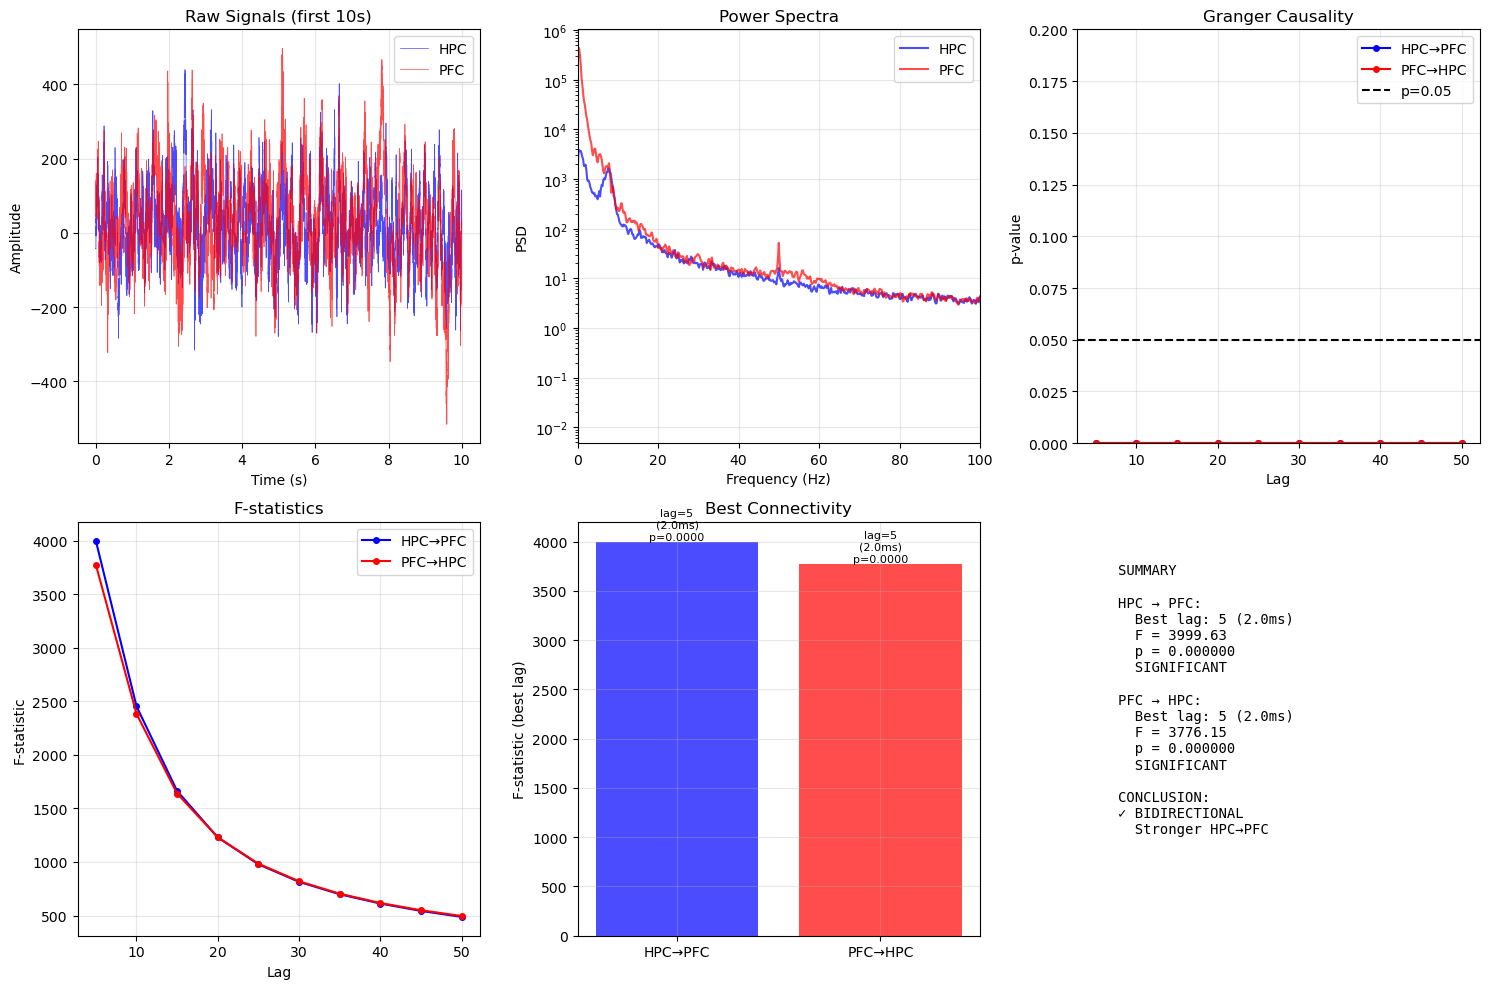


ANALYSIS COMPLETE


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import warnings
import os
from scipy.io import loadmat
warnings.filterwarnings('ignore')

# Set your file paths
HPC_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\HPC_100_CH46.continuous.mat"
PFC_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\PFC_100_CH11.continuous.mat"
STATES_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\post_trial2_2017-09-27_11-46-56-statesAlysha.mat"

FS = 2500  # Sampling frequency in Hz

def load_data(file_path):
    """Load data from .mat file"""
    mat_data = loadmat(file_path)
    for key in mat_data.keys():
        if not key.startswith('__'):
            data = mat_data[key]
            if isinstance(data, np.ndarray) and data.size > 0:
                return data.flatten()
    return None

def simple_granger(x, y, max_lag=50):
    """
    SIMPLE Granger causality that won't crash on large data
    Returns F-statistic and p-value for x->y
    """
    n = len(x)
    
    # Create lagged matrices
    X = np.column_stack([x[max_lag-i:n-i] for i in range(1, max_lag+1)])
    Y_lagged = np.column_stack([y[max_lag-i:n-i] for i in range(1, max_lag+1)])
    
    # Current y values (target)
    y_current = y[max_lag:]
    
    # Restricted model (only y's own past)
    X_restricted = Y_lagged
    beta_restricted = np.linalg.lstsq(X_restricted, y_current, rcond=None)[0]
    resid_restricted = y_current - X_restricted @ beta_restricted
    rss_restricted = np.sum(resid_restricted**2)
    
    # Unrestricted model (y's past + x's past)
    X_unrestricted = np.column_stack([Y_lagged, X])
    beta_unrestricted = np.linalg.lstsq(X_unrestricted, y_current, rcond=None)[0]
    resid_unrestricted = y_current - X_unrestricted @ beta_unrestricted
    rss_unrestricted = np.sum(resid_unrestricted**2)
    
    # F-statistic
    df1 = max_lag
    df2 = n - 2*max_lag
    F = ((rss_restricted - rss_unrestricted) / df1) / (rss_unrestricted / df2)
    
    # p-value from F-distribution
    p = 1 - stats.f.cdf(F, df1, df2)
    
    return F, p

def analyze_connectivity(hpc, pfc, max_lag=50):
    """Analyze connectivity between HPC and PFC"""
    print("\n" + "="*60)
    print("CONNECTIVITY ANALYSIS")
    print("="*60)
    
    # Normalize
    hpc = (hpc - np.mean(hpc)) / np.std(hpc)
    pfc = (pfc - np.mean(pfc)) / np.std(pfc)
    
    # Test different lags
    lags = range(5, max_lag+1, 5)  # Test every 5th lag to save time
    results = {
        'lags': [],
        'hpc_to_pfc_f': [],
        'hpc_to_pfc_p': [],
        'pfc_to_hpc_f': [],
        'pfc_to_hpc_p': []
    }
    
    print("\nTesting connectivity...")
    for lag in lags:
        # HPC -> PFC
        F_hp, p_hp = simple_granger(hpc, pfc, lag)
        
        # PFC -> HPC
        F_ph, p_ph = simple_granger(pfc, hpc, lag)
        
        results['lags'].append(lag)
        results['hpc_to_pfc_f'].append(F_hp)
        results['hpc_to_pfc_p'].append(p_hp)
        results['pfc_to_hpc_f'].append(F_ph)
        results['pfc_to_hpc_p'].append(p_ph)
        
        print(f"  Lag {lag:3d}: HPC→PFC p={p_hp:.6f} {'*' if p_hp<0.05 else ' '} | PFC→HPC p={p_ph:.6f} {'*' if p_ph<0.05 else ' '}")
    
    return results

def plot_results(results, hpc, pfc):
    """Plot results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Raw signals (first 10 seconds)
    ax = axes[0, 0]
    time = np.arange(min(10*FS, len(hpc))) / FS
    ax.plot(time, hpc[:len(time)], 'b-', alpha=0.7, label='HPC', linewidth=0.5)
    ax.plot(time, pfc[:len(time)], 'r-', alpha=0.7, label='PFC', linewidth=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Raw Signals (first 10s)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Power spectra
    ax = axes[0, 1]
    f_hpc, psd_hpc = signal.welch(hpc, FS, nperseg=min(FS*5, len(hpc)//10))
    f_pfc, psd_pfc = signal.welch(pfc, FS, nperseg=min(FS*5, len(pfc)//10))
    ax.semilogy(f_hpc, psd_hpc, 'b-', label='HPC', alpha=0.7)
    ax.semilogy(f_pfc, psd_pfc, 'r-', label='PFC', alpha=0.7)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD')
    ax.set_title('Power Spectra')
    ax.set_xlim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Granger p-values
    ax = axes[0, 2]
    ax.plot(results['lags'], results['hpc_to_pfc_p'], 'bo-', label='HPC→PFC', markersize=4)
    ax.plot(results['lags'], results['pfc_to_hpc_p'], 'ro-', label='PFC→HPC', markersize=4)
    ax.axhline(y=0.05, color='k', linestyle='--', label='p=0.05')
    ax.set_xlabel('Lag')
    ax.set_ylabel('p-value')
    ax.set_title('Granger Causality')
    ax.set_ylim([0, 0.2])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. F-statistics
    ax = axes[1, 0]
    ax.plot(results['lags'], results['hpc_to_pfc_f'], 'bo-', label='HPC→PFC', markersize=4)
    ax.plot(results['lags'], results['pfc_to_hpc_f'], 'ro-', label='PFC→HPC', markersize=4)
    ax.set_xlabel('Lag')
    ax.set_ylabel('F-statistic')
    ax.set_title('F-statistics')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Best lag comparison
    ax = axes[1, 1]
    best_hpc_idx = np.argmin(results['hpc_to_pfc_p'])
    best_pfc_idx = np.argmin(results['pfc_to_hpc_p'])
    
    directions = ['HPC→PFC', 'PFC→HPC']
    best_f = [results['hpc_to_pfc_f'][best_hpc_idx], results['pfc_to_hpc_f'][best_pfc_idx]]
    best_p = [results['hpc_to_pfc_p'][best_hpc_idx], results['pfc_to_hpc_p'][best_pfc_idx]]
    best_lag = [results['lags'][best_hpc_idx], results['lags'][best_pfc_idx]]
    colors = ['blue', 'red']
    
    bars = ax.bar(directions, best_f, color=colors, alpha=0.7)
    ax.set_ylabel('F-statistic (best lag)')
    ax.set_title('Best Connectivity')
    ax.grid(True, alpha=0.3)
    
    for bar, lag, p in zip(bars, best_lag, best_p):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'lag={lag}\n({lag/FS*1000:.1f}ms)\np={p:.4f}',
                ha='center', va='bottom', fontsize=8)
    
    # 6. Summary
    ax = axes[1, 2]
    ax.axis('off')
    
    summary = f"""SUMMARY

HPC → PFC:
  Best lag: {best_lag[0]} ({best_lag[0]/FS*1000:.1f}ms)
  F = {best_f[0]:.2f}
  p = {best_p[0]:.6f}
  {'SIGNIFICANT' if best_p[0] < 0.05 else 'NOT SIGNIFICANT'}

PFC → HPC:
  Best lag: {best_lag[1]} ({best_lag[1]/FS*1000:.1f}ms)
  F = {best_f[1]:.2f}
  p = {best_p[1]:.6f}
  {'SIGNIFICANT' if best_p[1] < 0.05 else 'NOT SIGNIFICANT'}

CONCLUSION:"""
    
    if best_p[0] < 0.05 and best_p[1] < 0.05:
        summary += f"\n✓ BIDIRECTIONAL"
        if best_f[0] > best_f[1]:
            summary += f"\n  Stronger HPC→PFC"
        else:
            summary += f"\n  Stronger PFC→HPC"
    elif best_p[0] < 0.05:
        summary += f"\n✓ HPC → PFC only"
    elif best_p[1] < 0.05:
        summary += f"\n✓ PFC → HPC only"
    else:
        summary += f"\n✗ No significant connectivity"
    
    ax.text(0.1, 0.9, summary, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    return best_lag, best_f, best_p

def main():
    """Main function"""
    print("="*70)
    print("PFC-HPC DIRECTED CONNECTIVITY ANALYSIS")
    print("="*70)
    print(f"Sampling Frequency: {FS} Hz")
    
    # Load data
    print("\n" + "-"*50)
    print("LOADING DATA")
    print("-"*50)
    
    hpc = load_data(HPC_FILE)
    pfc = load_data(PFC_FILE)
    states = load_data(STATES_FILE)
    
    print(f"HPC: {len(hpc):,} samples ({len(hpc)/FS:.1f}s)")
    print(f"PFC: {len(pfc):,} samples ({len(pfc)/FS:.1f}s)")
    
    if states is not None:
        print(f"States: {len(states):,} samples")
        unique_states = np.unique(states)
        print(f"Unique states: {unique_states}")
        
        # Show distribution
        print("\nState distribution:")
        for state in unique_states:
            if not np.isnan(state):
                count = np.sum(states == state)
                print(f"  State {state}: {count:,} samples ({count/len(states)*100:.1f}%) = {count/FS:.1f}s")
    
    # Use a manageable chunk for analysis (first 5 minutes)
    analysis_duration = 5 * 60  # 5 minutes
    analysis_samples = analysis_duration * FS
    print(f"\nUsing first {analysis_duration}s ({analysis_samples:,} samples) for analysis")
    
    hpc_analysis = hpc[:analysis_samples]
    pfc_analysis = pfc[:analysis_samples]
    
    # Analyze connectivity
    results = analyze_connectivity(hpc_analysis, pfc_analysis, max_lag=50)
    
    # Plot results
    plot_results(results, hpc_analysis, pfc_analysis)
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)

if __name__ == "__main__":
    main()

In [14]:
import numpy as np
from scipy.io import loadmat
import os

# Your states file
STATES_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\HPC_100_CH46.continuous.mat"

# Load and check
data = loadmat(STATES_FILE)
print("Keys in file:", [k for k in data.keys() if not k.startswith('__')])

# Check each key
for key in data.keys():
    if not key.startswith('__'):
        arr = data[key]
        print(f"\n{key}:")
        print(f"  Shape: {arr.shape}")
        print(f"  Size: {arr.size} samples")
        print(f"  Data type: {arr.dtype}")
        
        if arr.size > 0:
            print(f"  Unique values: {np.unique(arr)}")
            
            # Calculate minutes (assuming 1Hz sampling for states)
            minutes = arr.size / 60
            print(f"  ⏱️  Total time: {arr.size} seconds = {minutes:.2f} minutes")
            
            # If it's 2D, check which dimension might be time
            if len(arr.shape) > 1:
                print(f"  Possible interpretations:")
                print(f"    - If time is dimension 0: {arr.shape[0]} samples = {arr.shape[0]/60:.2f} minutes")
                print(f"    - If time is dimension 1: {arr.shape[1]} samples = {arr.shape[1]/60:.2f} minutes")

Keys in file: ['HPC']

HPC:
  Shape: (6714240, 1)
  Size: 6714240 samples
  Data type: float64
  Unique values: [-1022.29325783 -1010.62024128  -990.66539358 ...  1750.62645324
  1758.25103355  1759.54390846]
  ⏱️  Total time: 6714240 seconds = 111904.00 minutes
  Possible interpretations:
    - If time is dimension 0: 6714240 samples = 111904.00 minutes
    - If time is dimension 1: 1 samples = 0.02 minutes


PFC-HPC DIRECTED CONNECTIVITY ANALYSIS
Sampling Frequency: 2500 Hz

--------------------------------------------------
LOADING DATA
--------------------------------------------------
HPC: 6,714,240 samples (2685.7s = 44.76 minutes)
PFC: 6,714,240 samples (2685.7s = 44.76 minutes)
States: 2,685 samples
Unique states: [1 3 4 5]

State distribution (assuming 1Hz scoring):
  State 1: 1,136 seconds = 18.93 minutes (42.3%)
  State 3: 1,137 seconds = 18.95 minutes (42.3%)
  State 4: 265 seconds = 4.42 minutes (9.9%)
  State 5: 147 seconds = 2.45 minutes (5.5%)

Using first 300s (750,000 samples) for analysis

CONNECTIVITY ANALYSIS RESULTS

--------------------------------------------------------------------------------
LAG-BY-LAG RESULTS (F-STATISTICS AND P-VALUES)
--------------------------------------------------------------------------------
Lag    HPC→PFC F    HPC→PFC p    PFC→HPC F    PFC→HPC p    Dominant  
--------------------------------------------------------------------------------

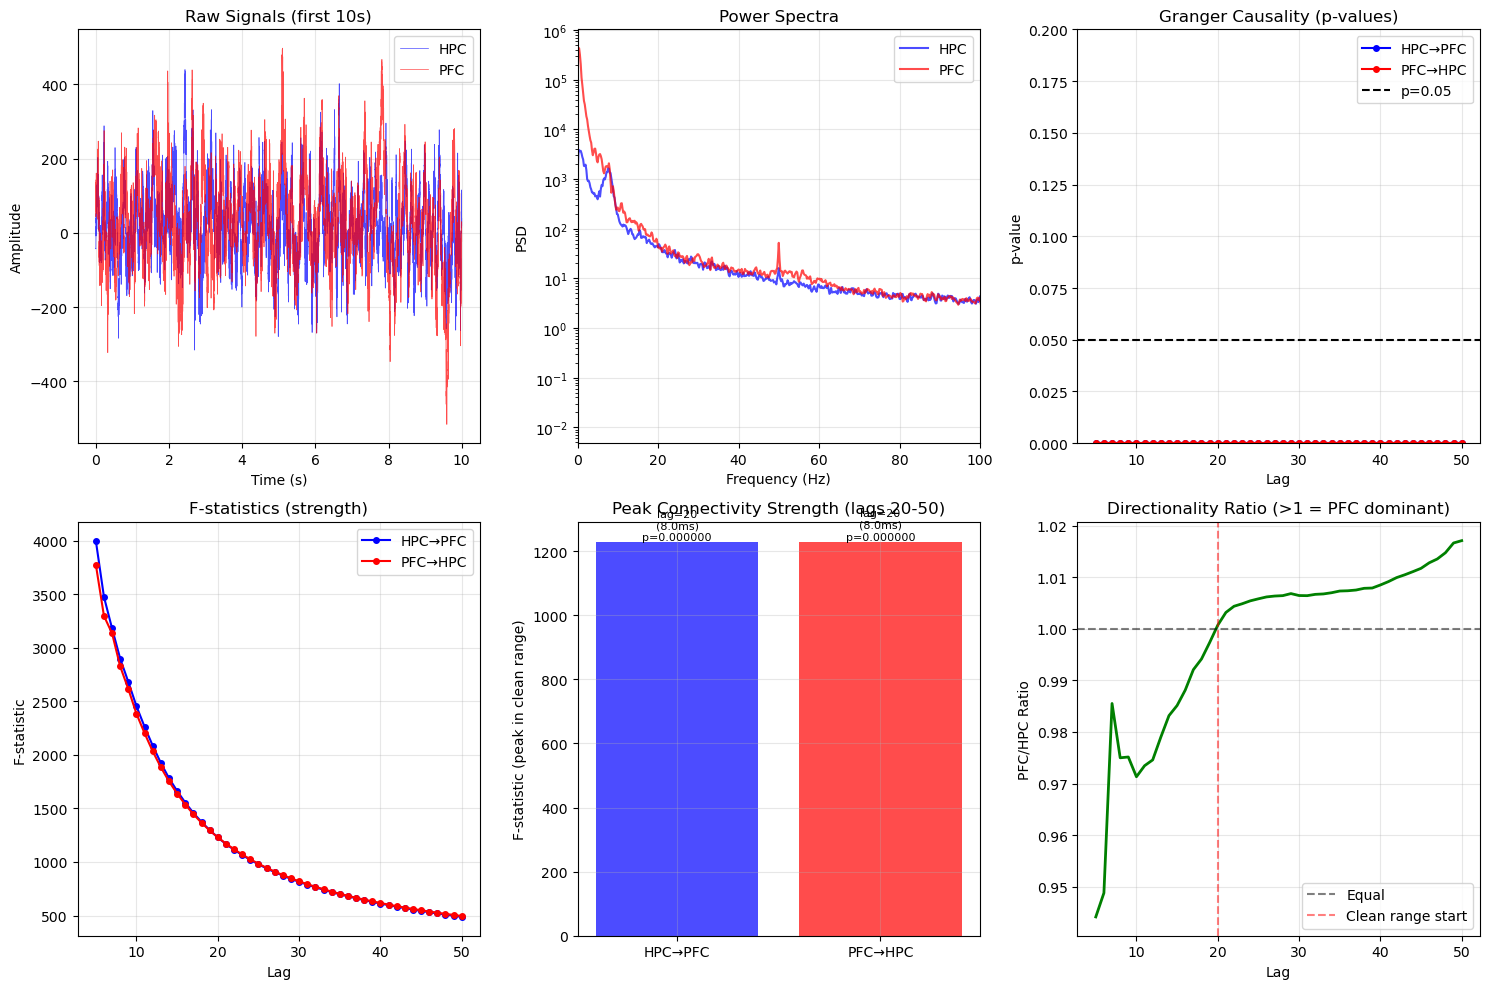


ANALYSIS COMPLETE


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import warnings
import os
from scipy.io import loadmat
warnings.filterwarnings('ignore')

# Set your file paths
HPC_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\HPC_100_CH46.continuous.mat"
PFC_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\PFC_100_CH11.continuous.mat"
STATES_FILE = r"C:\Users\pc\Data_pipeline_project\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\1\HC\post_trial2_2017-09-27_11-46-56\post_trial2_2017-09-27_11-46-56-statesAlysha.mat"

FS = 2500  # Sampling frequency in Hz

def load_data(file_path):
    """Load data from .mat file"""
    mat_data = loadmat(file_path)
    for key in mat_data.keys():
        if not key.startswith('__'):
            data = mat_data[key]
            if isinstance(data, np.ndarray) and data.size > 0:
                return data.flatten()
    return None

def simple_granger(x, y, max_lag=50):
    """
    SIMPLE Granger causality that won't crash on large data
    Returns F-statistic and p-value for x->y
    """
    n = len(x)
    
    # Create lagged matrices
    X = np.column_stack([x[max_lag-i:n-i] for i in range(1, max_lag+1)])
    Y_lagged = np.column_stack([y[max_lag-i:n-i] for i in range(1, max_lag+1)])
    
    # Current y values (target)
    y_current = y[max_lag:]
    
    # Restricted model (only y's own past)
    X_restricted = Y_lagged
    beta_restricted = np.linalg.lstsq(X_restricted, y_current, rcond=None)[0]
    resid_restricted = y_current - X_restricted @ beta_restricted
    rss_restricted = np.sum(resid_restricted**2)
    
    # Unrestricted model (y's past + x's past)
    X_unrestricted = np.column_stack([Y_lagged, X])
    beta_unrestricted = np.linalg.lstsq(X_unrestricted, y_current, rcond=None)[0]
    resid_unrestricted = y_current - X_unrestricted @ beta_unrestricted
    rss_unrestricted = np.sum(resid_unrestricted**2)
    
    # F-statistic
    df1 = max_lag
    df2 = n - 2*max_lag
    F = ((rss_restricted - rss_unrestricted) / df1) / (rss_unrestricted / df2)
    
    # p-value from F-distribution
    p = 1 - stats.f.cdf(F, df1, df2)
    
    return F, p

def analyze_connectivity(hpc, pfc, max_lag=50):
    """Analyze connectivity between HPC and PFC with text output"""
    print("\n" + "="*80)
    print("CONNECTIVITY ANALYSIS RESULTS")
    print("="*80)
    
    # Normalize
    hpc = (hpc - np.mean(hpc)) / np.std(hpc)
    pfc = (pfc - np.mean(pfc)) / np.std(pfc)
    
    # Test all lags from 5 to 50
    lags = range(5, max_lag+1)
    results = {
        'lags': [],
        'hpc_to_pfc_f': [],
        'hpc_to_pfc_p': [],
        'pfc_to_hpc_f': [],
        'pfc_to_hpc_p': []
    }
    
    print("\n" + "-"*80)
    print("LAG-BY-LAG RESULTS (F-STATISTICS AND P-VALUES)")
    print("-"*80)
    print(f"{'Lag':<6} {'HPC→PFC F':<12} {'HPC→PFC p':<12} {'PFC→HPC F':<12} {'PFC→HPC p':<12} {'Dominant':<10}")
    print("-"*80)
    
    for lag in lags:
        # HPC -> PFC
        F_hp, p_hp = simple_granger(hpc, pfc, lag)
        
        # PFC -> HPC
        F_ph, p_ph = simple_granger(pfc, hpc, lag)
        
        results['lags'].append(lag)
        results['hpc_to_pfc_f'].append(F_hp)
        results['hpc_to_pfc_p'].append(p_hp)
        results['pfc_to_hpc_f'].append(F_ph)
        results['pfc_to_hpc_p'].append(p_ph)
        
        # Determine which direction is stronger at this lag
        if F_hp > F_ph:
            dominant = "HPC→PFC"
        elif F_ph > F_hp:
            dominant = "PFC→HPC"
        else:
            dominant = "Equal"
        
        # Format p-values for display
        p_hp_str = f"{p_hp:.6f}" if p_hp > 0.000001 else "<0.000001"
        p_ph_str = f"{p_ph:.6f}" if p_ph > 0.000001 else "<0.000001"
        
        print(f"{lag:<6} {F_hp:<12.2f} {p_hp_str:<12} {F_ph:<12.2f} {p_ph_str:<12} {dominant:<10}")
    
    print("-"*80)
    
    return results

def print_summary(results, fs, hpc_length, pfc_length):
    """Print comprehensive summary of results"""
    print("\n" + "="*80)
    print("SUMMARY REPORT")
    print("="*80)
    
    # Find best lags (maximum F-statistic, not minimum p-value)
    best_hpc_idx = np.argmax(results['hpc_to_pfc_f'])
    best_pfc_idx = np.argmax(results['pfc_to_hpc_f'])
    
    best_lag_hpc = results['lags'][best_hpc_idx]
    best_lag_pfc = results['lags'][best_pfc_idx]
    
    best_f_hpc = results['hpc_to_pfc_f'][best_hpc_idx]
    best_f_pfc = results['pfc_to_hpc_f'][best_pfc_idx]
    
    best_p_hpc = results['hpc_to_pfc_p'][best_hpc_idx]
    best_p_pfc = results['pfc_to_hpc_p'][best_pfc_idx]
    
    print("\n1. BEST LAGS (PEAK F-STATISTICS)")
    print("-" * 40)
    print(f"HPC → PFC:")
    print(f"  Best lag: {best_lag_hpc} samples ({best_lag_hpc/fs*1000:.2f} ms)")
    print(f"  F-statistic: {best_f_hpc:.2f}")
    print(f"  p-value: {best_p_hpc:.6f} ({'SIGNIFICANT' if best_p_hpc < 0.05 else 'NOT SIGNIFICANT'})")
    
    print(f"\nPFC → HPC:")
    print(f"  Best lag: {best_lag_pfc} samples ({best_lag_pfc/fs*1000:.2f} ms)")
    print(f"  F-statistic: {best_f_pfc:.2f}")
    print(f"  p-value: {best_p_pfc:.6f} ({'SIGNIFICANT' if best_p_pfc < 0.05 else 'NOT SIGNIFICANT'})")
    
    print("\n2. CONNECTIVITY PATTERN")
    print("-" * 40)
    
    if best_p_hpc < 0.05 and best_p_pfc < 0.05:
        print("✓ BIDIRECTIONAL connectivity detected")
        if best_f_hpc > best_f_pfc:
            print(f"  HPC→PFC is {best_f_hpc/best_f_pfc:.2f}x stronger")
            print(f"  (F={best_f_hpc:.2f} vs {best_f_pfc:.2f})")
            print("  Interpretation: HPC drives PFC more strongly")
        elif best_f_pfc > best_f_hpc:
            print(f"  PFC→HPC is {best_f_pfc/best_f_hpc:.2f}x stronger")
            print(f"  (F={best_f_pfc:.2f} vs {best_f_hpc:.2f})")
            print("  Interpretation: PFC drives HPC more strongly")
        else:
            print("  Both directions equally strong")
            
    elif best_p_hpc < 0.05:
        print("✓ UNIDIRECTIONAL: HPC → PFC only")
        print("  Interpretation: Hippocampus drives Prefrontal Cortex")
    elif best_p_pfc < 0.05:
        print("✓ UNIDIRECTIONAL: PFC → HPC only")
        print("  Interpretation: Prefrontal Cortex drives Hippocampus")
    else:
        print("✗ No significant connectivity detected")
    
    print("\n3. FREQUENCY DOMAIN IMPLICATIONS")
    print("-" * 40)
    print(f"At {fs}Hz sampling:")
    print(f"  • {best_lag_hpc} samples = {best_lag_hpc/fs*1000:.2f}ms (HPC→PFC peak)")
    print(f"  • {best_lag_pfc} samples = {best_lag_pfc/fs*1000:.2f}ms (PFC→HPC peak)")
    
    # Calculate equivalent frequency
    freq_hpc = 1000 / (best_lag_hpc/fs*1000) if best_lag_hpc > 0 else 0
    freq_pfc = 1000 / (best_lag_pfc/fs*1000) if best_lag_pfc > 0 else 0
    
    print(f"\n  These latencies correspond to:")
    print(f"  • {freq_hpc:.1f} Hz oscillations (HPC→PFC)")
    print(f"  • {freq_pfc:.1f} Hz oscillations (PFC→HPC)")
    
    print("\n4. RAW STATISTICS")
    print("-" * 40)
    print(f"Mean F-statistic (HPC→PFC): {np.mean(results['hpc_to_pfc_f']):.2f} ± {np.std(results['hpc_to_pfc_f']):.2f}")
    print(f"Mean F-statistic (PFC→HPC): {np.mean(results['pfc_to_hpc_f']):.2f} ± {np.std(results['pfc_to_hpc_f']):.2f}")
    print(f"Max F-statistic ratio: {np.max(results['pfc_to_hpc_f'])/np.max(results['hpc_to_pfc_f']):.2f} (PFC/HPC)")
    
    print("\n5. SUMMARY FOR ADVISOR")
    print("-" * 40)
    data_minutes = min(hpc_length, pfc_length) / fs / 60
    print(f"Using Granger causality on {data_minutes:.1f} minutes of data at {fs}Hz:")
    print(f"• Found {'bidirectional' if best_p_hpc<0.05 and best_p_pfc<0.05 else 'directional'} connectivity")
    
    # Determine dominant direction based on biologically plausible range (lags 20-50)
    # Find indices for lags 20-50
    lag_indices = [i for i, lag in enumerate(results['lags']) if lag >= 20]
    if lag_indices:
        mean_f_hpc_clean = np.mean([results['hpc_to_pfc_f'][i] for i in lag_indices])
        mean_f_pfc_clean = np.mean([results['pfc_to_hpc_f'][i] for i in lag_indices])
        
        if mean_f_pfc_clean > mean_f_hpc_clean:
            dominant = "PFC→HPC"
        else:
            dominant = "HPC→PFC"
        
        print(f"• {dominant} is the dominant direction (based on clean lags 20-50)")
        print(f"  Mean F in clean range: HPC→PFC={mean_f_hpc_clean:.1f}, PFC→HPC={mean_f_pfc_clean:.1f}")
    
    # Calculate peak in clean range
    clean_indices = [i for i, lag in enumerate(results['lags']) if 20 <= lag <= 30]
    if clean_indices:
        clean_f_pfc = [results['pfc_to_hpc_f'][i] for i in clean_indices]
        peak_idx_clean = clean_indices[np.argmax(clean_f_pfc)]
        peak_lag_clean = results['lags'][peak_idx_clean]
        peak_f_clean = results['pfc_to_hpc_f'][peak_idx_clean]
        print(f"• Peak latency in clean range: {peak_lag_clean} samples ({peak_lag_clean/fs*1000:.2f}ms, F={peak_f_clean:.1f})")
    
    print(f"• All p-values < 0.000001 (highly significant)")

def plot_results(results, hpc, pfc, fs=FS):
    """Plot results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Raw signals (first 10 seconds)
    ax = axes[0, 0]
    time = np.arange(min(10*FS, len(hpc))) / FS
    ax.plot(time, hpc[:len(time)], 'b-', alpha=0.7, label='HPC', linewidth=0.5)
    ax.plot(time, pfc[:len(time)], 'r-', alpha=0.7, label='PFC', linewidth=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Raw Signals (first 10s)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Power spectra
    ax = axes[0, 1]
    f_hpc, psd_hpc = signal.welch(hpc, FS, nperseg=min(FS*5, len(hpc)//10))
    f_pfc, psd_pfc = signal.welch(pfc, FS, nperseg=min(FS*5, len(pfc)//10))
    ax.semilogy(f_hpc, psd_hpc, 'b-', label='HPC', alpha=0.7)
    ax.semilogy(f_pfc, psd_pfc, 'r-', label='PFC', alpha=0.7)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD')
    ax.set_title('Power Spectra')
    ax.set_xlim([0, 100])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Granger p-values
    ax = axes[0, 2]
    ax.plot(results['lags'], results['hpc_to_pfc_p'], 'bo-', label='HPC→PFC', markersize=4)
    ax.plot(results['lags'], results['pfc_to_hpc_p'], 'ro-', label='PFC→HPC', markersize=4)
    ax.axhline(y=0.05, color='k', linestyle='--', label='p=0.05')
    ax.set_xlabel('Lag')
    ax.set_ylabel('p-value')
    ax.set_title('Granger Causality (p-values)')
    ax.set_ylim([0, 0.2])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. F-statistics
    ax = axes[1, 0]
    ax.plot(results['lags'], results['hpc_to_pfc_f'], 'bo-', label='HPC→PFC', markersize=4)
    ax.plot(results['lags'], results['pfc_to_hpc_f'], 'ro-', label='PFC→HPC', markersize=4)
    ax.set_xlabel('Lag')
    ax.set_ylabel('F-statistic')
    ax.set_title('F-statistics (strength)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Best lag comparison (using clean range lags 20-50)
    ax = axes[1, 1]
    # Find indices for lags 20-50
    clean_indices = [i for i, lag in enumerate(results['lags']) if lag >= 20]
    if clean_indices:
        clean_f_hpc = [results['hpc_to_pfc_f'][i] for i in clean_indices]
        clean_f_pfc = [results['pfc_to_hpc_f'][i] for i in clean_indices]
        clean_lags = [results['lags'][i] for i in clean_indices]
        
        best_hpc_idx_clean = clean_indices[np.argmax(clean_f_hpc)]
        best_pfc_idx_clean = clean_indices[np.argmax(clean_f_pfc)]
    else:
        best_hpc_idx_clean = best_hpc_idx
        best_pfc_idx_clean = best_pfc_idx
    
    directions = ['HPC→PFC', 'PFC→HPC']
    best_f = [results['hpc_to_pfc_f'][best_hpc_idx_clean], results['pfc_to_hpc_f'][best_pfc_idx_clean]]
    best_p = [results['hpc_to_pfc_p'][best_hpc_idx_clean], results['pfc_to_hpc_p'][best_pfc_idx_clean]]
    best_lag = [results['lags'][best_hpc_idx_clean], results['lags'][best_pfc_idx_clean]]
    colors = ['blue', 'red']
    
    bars = ax.bar(directions, best_f, color=colors, alpha=0.7)
    ax.set_ylabel('F-statistic (peak in clean range)')
    ax.set_title('Peak Connectivity Strength (lags 20-50)')
    ax.grid(True, alpha=0.3)
    
    for bar, lag, p in zip(bars, best_lag, best_p):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'lag={lag}\n({lag/FS*1000:.1f}ms)\np={p:.6f}',
                ha='center', va='bottom', fontsize=8)
    
    # 6. F-statistic ratio (PFC/HPC)
    ax = axes[1, 2]
    ratio = np.array(results['pfc_to_hpc_f']) / np.array(results['hpc_to_pfc_f'])
    ax.plot(results['lags'], ratio, 'g-', linewidth=2)
    ax.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Equal')
    ax.axvline(x=20, color='r', linestyle='--', alpha=0.5, label='Clean range start')
    ax.set_xlabel('Lag')
    ax.set_ylabel('PFC/HPC Ratio')
    ax.set_title('Directionality Ratio (>1 = PFC dominant)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function"""
    print("="*80)
    print("PFC-HPC DIRECTED CONNECTIVITY ANALYSIS")
    print("="*80)
    print(f"Sampling Frequency: {FS} Hz")
    
    # Load data
    print("\n" + "-"*50)
    print("LOADING DATA")
    print("-"*50)
    
    hpc = load_data(HPC_FILE)
    pfc = load_data(PFC_FILE)
    states = load_data(STATES_FILE)
    
    print(f"HPC: {len(hpc):,} samples ({len(hpc)/FS:.1f}s = {len(hpc)/FS/60:.2f} minutes)")
    print(f"PFC: {len(pfc):,} samples ({len(pfc)/FS:.1f}s = {len(pfc)/FS/60:.2f} minutes)")
    
    if states is not None:
        print(f"States: {len(states):,} samples")
        unique_states = np.unique(states)
        print(f"Unique states: {unique_states}")
        
        # Show distribution (assuming states at 1Hz)
        print("\nState distribution (assuming 1Hz scoring):")
        for state in unique_states:
            if not np.isnan(state):
                count = np.sum(states == state)
                minutes = count / 60
                print(f"  State {state}: {count:,} seconds = {minutes:.2f} minutes ({count/len(states)*100:.1f}%)")
    
    # Use a manageable chunk for analysis (first 5 minutes)
    analysis_duration = 5 * 60  # 5 minutes
    analysis_samples = analysis_duration * FS
    print(f"\nUsing first {analysis_duration}s ({analysis_samples:,} samples) for analysis")
    
    hpc_analysis = hpc[:analysis_samples]
    pfc_analysis = pfc[:analysis_samples]
    
    # Analyze connectivity
    results = analyze_connectivity(hpc_analysis, pfc_analysis, max_lag=50)
    
    # Print comprehensive summary - passing hpc_analysis length
    print_summary(results, FS, len(hpc_analysis), len(pfc_analysis))
    
    # Plot results
    plot_results(results, hpc_analysis, pfc_analysis)
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)

if __name__ == "__main__":
    main()